# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random as rn
import pandas as pd


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications.resnet50 import ResNet50

tf.random.set_seed(0)
np.random.seed(0) 
rn.seed(0)

print(tf.version.VERSION)

2.6.0


In [2]:
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback

In [3]:
PATH = './datasets'
PATH_TRAIN = './datasets/dataset.csv'
PATH_TEST = './datasets/test_dataset.csv'

BATCH_SIZE = 128

In [4]:

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")
#limit_mem()


A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
df_train_image = pd.read_csv(PATH_TRAIN)
df_test_image = pd.read_csv(PATH_TEST)
df_train_numerical = pd.read_csv('./datasets/numerical_train.csv')
df_teste_numerical = pd.read_csv('./datasets/numerical_teste.csv')

x_train_images = df_train_image.values
x_test_images = df_test_image.values
x_train_numerical =  df_train_numerical.values[:, 1:]
x_test_numerical = df_teste_numerical.values

y_train = df_train_numerical.values[:, 0]


x_train_images = x_train_images.astype('float32')
x_test_images = x_test_images.astype('float32')
x_train_numerical = x_train_numerical.astype('float32')
x_test_numerical = x_test_numerical.astype('float32')


y_train = y_train.astype('float32')

x_train_images = x_train_images.reshape(-1, 90, 90, 1)
x_test_images = x_test_images.reshape(-1, 90, 90, 1)

In [6]:
x_train_images, x_val_images, y_train_img, y_val_img = train_test_split(x_train_images,y_train, test_size=0.15, random_state=0)
x_train_numerical, x_val_numerical, y_train_numerical, y_val_numerical = train_test_split(x_train_numerical,y_train, test_size=0.15, random_state=0)

## 1.1 Visualizar os Dados

In [7]:
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(10, input_dim=dim, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(20, input_dim=dim, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(200, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

In [8]:
def create_cnn(width, height, depth, filters=(64,128,256,512), regress=False):
    inputShape = (height, width,depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        x = Conv2D(f, 3, padding="same", data_format ="channels_last", input_shape=(90,90,1))(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
    x = Dense(64)(x)
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(5)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [39]:
mlp = create_mlp(x_train_numerical.shape[1])
cnn = create_cnn(90, 90, 1)
combinedInput = concatenate([mlp.output,cnn.output])
x = Dense(32, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# input and images on the CNN input, outputting a single value (the predicted age)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = Adam(learning_rate=0.001)
#pt = SGD(learning_rate=0.001)
#pt = RMSprop(learning_rate = 0.001)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mae'])

In [40]:
model.summary( )

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 90, 90, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 90, 90, 64)   640         input_3[0][0]                    
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 90, 90, 64)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 90, 90, 64)   256         activation_12[0][0]              
____________________________________________________________________________________________

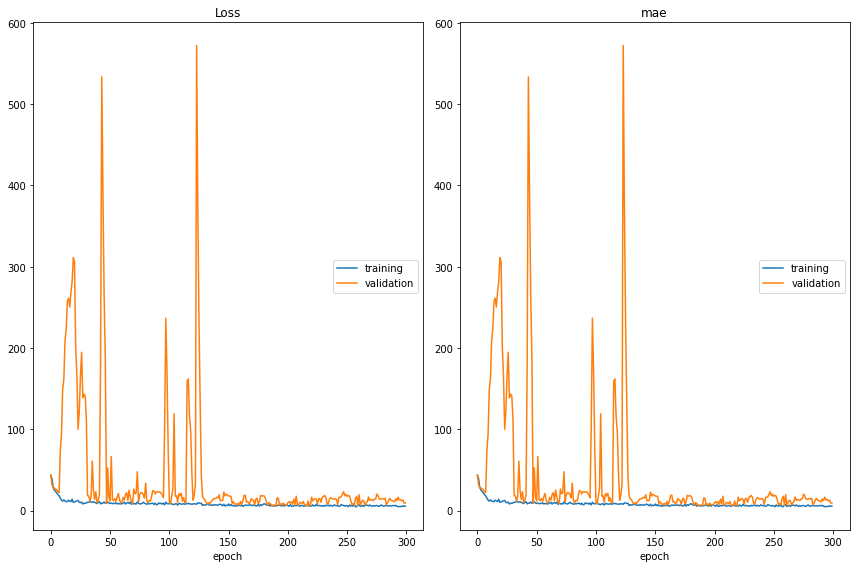

Loss
	training         	 (min:    4.789, max:   43.276, cur:    5.523)
	validation       	 (min:    5.716, max:  572.140, cur:    9.342)
mae
	training         	 (min:    4.789, max:   43.276, cur:    5.523)
	validation       	 (min:    5.716, max:  572.140, cur:    9.342)


In [41]:
# train the model
print("[INFO] training model...")
history = model.fit(
    x=[x_train_numerical, x_train_images], y=y_train_img,
    validation_data=([x_val_numerical, x_val_images], y_val_img),
    epochs=300, batch_size=5,verbose=0,callbacks=[PlotLossesKeras()])
# make predictions on the testing data
preds = model.predict([x_train_numerical, x_train_images])

In [31]:
preds = model.predict([x_test_numerical, x_test_images])

In [32]:
resultados = []
for x in preds:
    resultados.append(round(x[0]))
resultados

[22,
 20,
 22,
 29,
 21,
 31,
 58,
 57,
 53,
 73,
 62,
 42,
 59,
 60,
 25,
 30,
 32,
 55,
 22,
 40,
 59,
 60,
 90,
 83,
 65,
 60,
 96,
 68]

In [33]:
df = pd.DataFrame(resultados)
df

,0
0,22
1,20
2,22
3,29
4,21
5,31
6,58
7,57
8,53
9,73


In [35]:
df.index = np.arange(1, len(df)+1)
df.to_csv('datasets/submission1.csv',header=['age'])